# Loading data

In [1]:
#importing libraries
import numpy as np
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import cv2 as cv
import os
import scipy


In [2]:
image_path = 'dataset/face_age/'

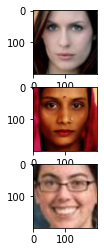

In [3]:
# plot sample images

def see_sample_images(age, number_of_images):
    age_folder = image_path + age
    images = os.listdir(age_folder)[:number_of_images]
    fig, axs = plt.subplots(number_of_images)
    for i in range(number_of_images):
        img = plt.imread(age_folder +'/'+ images[i])
        axs[i].imshow(img)
    
see_sample_images("033",3)

# Create Dataset

In [4]:
X = []
Y = []

for folder_name,_,filenames in os.walk(image_path):
    if folder_name !="face_age" and folder_name != 'Data':
        for file in filenames:
            file_path = folder_name +"/"+ file
            image = cv.imread(file_path)
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image = cv.resize(image, (100, 100), interpolation=cv.INTER_AREA)
            X.append(np.array(image))
            Y.append(int(folder_name[-3:]))
    else:
        pass
    
sys.getsizeof(X)

85176

# Preprocess

In [5]:
X = np.array(X)
X = X.astype('float32')
X /= 255.0
Y = np.array(Y)

In [6]:
print(X.shape, Y.shape)

(9778, 100, 100, 3) (9778,)


# EDA

Text(0, 0.5, 'Number of Images')

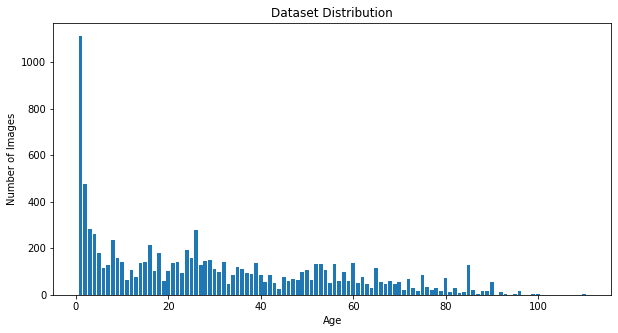

In [7]:
age_count = pd.Series(Y).value_counts()

plt.figure(figsize=(10,5))

plt.bar(age_count.index, age_count.values)

plt.title('Dataset Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')

# Split training set

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

# Augmentation and preparation

## Augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator(
)

## Callbacks

In [10]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=5, # wait for 5 epochs
                                min_delta = 0.01, # if in 5 epochs the loss function doesn't inrease (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, # if val_loss plateaus for 3 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.01,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 4, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

## Training history plot

In [11]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    mae = history.history['mean_absolute_error'] 
    val_mae = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    plt.plot(epochs, mae, 'b', label='Training mae')
    plt.plot(epochs, val_mae, 'g', label='Validation mae')
    plt.title('Training and validation mean_absolute_error')
    plt.legend()

    plt.show()

## Preprocessing function for test image

In [22]:
def preprocess_test(img):
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    width = 100
    height = 100
    resize_img = cv.resize(rgb_img, (width,height), interpolation=cv.INTER_AREA)
    return np.array(resize_img)/255.0

# Model 1

## Create Model

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation, GlobalMaxPool2D,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

from tensorflow.keras.applications.mobilenet import MobileNet

In [14]:
# hyperparameters
lr = 0.01
epochs = 100 
batch_size = 128
results = {}
input_shape =[100, 100]
num_of_ages = 100

In [24]:
def mobilenet():
    base_mobilenet_model = MobileNet(input_shape =  (100,100, 3), 
                                 include_top = False, 
                                 weights = None)
    mobilenet_model = Sequential()
    mobilenet_model.add(BatchNormalization(input_shape = (input_shape[0],input_shape[1], 3)))
    mobilenet_model.add(base_mobilenet_model)
    mobilenet_model.add(BatchNormalization())
    mobilenet_model.add(GlobalAveragePooling2D())
    mobilenet_model.add(Dropout(0.5))
    mobilenet_model.add(Dense(1,activation='linear')) 
    return mobilenet_model

In [ ]:
model1 = mobilenet()

model1.summary()

## Training

In [17]:
model1.compile(optimizer="adam",loss="mean_absolute_error",metrics=['mean_absolute_error'])

model1_history = model1.fit_generator(
            train_datagen.flow(X_train,Y_train,
                         batch_size = batch_size), 
            validation_data = (X_val,Y_val),
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ],
            verbose=True)

C:\Users\PALM-L~1\AppData\Local\Temp/ipykernel_26124/1052074561.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1_history = model1.fit_generator(


Epoch 1/100
54/54 [==============================] - 34s 498ms/step - loss: 28.4071 - mean_absolute_error: 28.4071 - val_loss: 26.3333 - val_mean_absolute_error: 26.3333 - lr: 0.0010
Epoch 2/100
54/54 [==============================] - 22s 405ms/step - loss: 23.7553 - mean_absolute_error: 23.7553 - val_loss: 21.7985 - val_mean_absolute_error: 21.7985 - lr: 0.0010
Epoch 3/100
54/54 [==============================] - 22s 411ms/step - loss: 16.4726 - mean_absolute_error: 16.4726 - val_loss: 20.1516 - val_mean_absolute_error: 20.1516 - lr: 0.0010
Epoch 4/100
54/54 [==============================] - 22s 402ms/step - loss: 12.9191 - mean_absolute_error: 12.9191 - val_loss: 20.3502 - val_mean_absolute_error: 20.3502 - lr: 0.0010
Epoch 5/100
54/54 [==============================] - 22s 401ms/step - loss: 11.0519 - mean_absolute_error: 11.0519 - val_loss: 20.3492 - val_mean_absolute_error: 20.3492 - lr: 0.0010
Epoch 6/100
54/54 [==============================] - ETA: 0s - loss: 9.9292 - mean_ab

In [18]:
model1.save('models/model1')

INFO:tensorflow:Assets written to: models/model1\assets


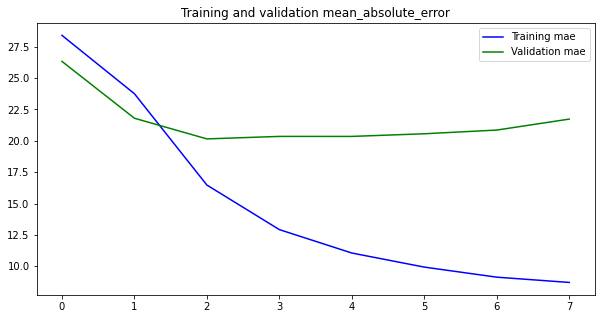

In [19]:
plot_history(model1_history)

## Inferencing

[33.84686]


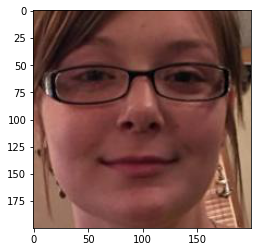

In [20]:
test_img = cv.imread(image_path+"/020/1410.png")
plt.imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB))
preprocessed_test_img = preprocess_test(test_img)
print(*model1.predict(np.array([preprocessed_test_img])))

[33.8743]


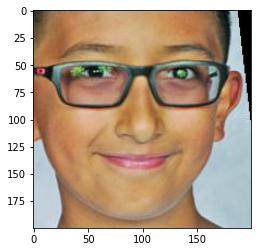

In [21]:
test_img = cv.imread(image_path+"/013/500.png")
plt.imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB))
preprocessed_test_img = preprocess_test(test_img)
print(*model1.predict(np.array([preprocessed_test_img])))